# W251 - Final Projects - Skeggox Team

* Parham Motameni 
* Mitchell Karchemsky
* Lynn Marciano

The majority of parameters can be configured, including some of the optimization techniques. Check out the configuration section for details.


# Setup steps and import libraries

In [ ]:
%%capture
from pathlib import Path
data_path = 'grab.zip'
data_file = Path(data_path)
if data_file.is_file():
  print("Data file is already loaded.")
else :
  !pip install timm
  !pip install albumentations==0.4.6
  !pip install gdown
  # install wandb and tensorboard
  !pip install tensorboard
  !pip install wandb
  !mkdir -p 'grab'
  !mkdir -p 'checkpoints'
  !gdown --id '1c8thCkdHJaoF4hLffi8ne-ULh4FPrPdy' # images
  !unzip -qq 'grab.zip'
  !gdown --id '1Yf-IiNncjaHKI_qQq76p4wmW-FHTZSQu' #checkpoint
  !mv 'checkpoint.pth.tar' 'checkpoints/'

In [ ]:
import time
import os
from tqdm import tqdm_notebook as tqdm
#import tqdm.notebook import tqdm
import cv2
from PIL import Image
import pandas as pd
import torch
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch.utils.data import DataLoader, Dataset
from torch.optim import lr_scheduler
import matplotlib.pyplot as plt
import random
import numpy as np
import seaborn as sn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import shutil
import timm
import torch.nn.functional as F
from torch.nn.modules.loss import _WeightedLoss
import torchvision.datasets as datasets
from timm.scheduler.cosine_lr import CosineLRScheduler
from torch.cuda.amp import autocast, GradScaler
import torch.backends.cudnn as cudnn
import torchvision.models as models
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.tensorboard import SummaryWriter

import wandb
import warnings


warnings.filterwarnings('ignore')
%matplotlib inline

# Configuration

The majority of parameters can be configured, including some of the optimization techniques.

The following optimizations can be used by setting proper configuration arguments
1. Learning Rate Schedular - Step Schedular or CosineLRScheduler
2. Different arch using mixnet_xl 

The following optimizations are applied 
1. Mixup
2. Label Smoothing
3. Scaler for Mixed Precision

In [ ]:
class args:
  arch = 'mixnet_xl'
  # arch = 'efficientnet_b2' 
  batch_size = 15 #96
  beta = .1
  cudnn_benchmark = True
  cudnn_deterministic = True
  epochs = 100
  # epochs = 15
  folds = 8
  gpu = 0
  img_size = 224
  img_mean_RGB = [0.47889522, 0.47227842, 0.43047404]
  img_std_RGB = [0.229, 0.224, 0.225]
  log_level =  'verbose' # options: verbose, None
  lr = 0.0001 # learning rate
  lr_min=0.00001 # min learning rate when using a LR Scheduler
  momentum = 0.9 # a setting for Optimizer
  warmup_epochs = 2 # a setting for Cosine LR Scheduler
  num_classes = 3 # number of categories 
  num_workers = 8 
  pretrained = True # determine if the weights of pre-build model should be used 
  print_freq = 50
  project_name = 'skeggox'
  resume = False # when it is True it will continue from last saved checkpoint
  save_checkpoint = True # save both last and best acc checkpoints
  save_checkpoint_per_epoch = True # save one file per epoch along best acc 
  seed = 1
  schedular_type = 'step' # option: 'cosine', 'step'(DEFAULT)
  start_epoch = 0
  imgs_dir = 'grab/imgs'
  wandb_entity = 'skeggox'
  warm = 4
  warmup_lr_init = 0.00001 # for Cosine LR
  weight_decay = 0.00001

In [ ]:
class state:
  best_acc = 0
  start_epoch = 0

# Setup log/monitoring Tensorboard and WANDB 

In [ ]:
wandb.login()

wandb: Currently logged in as: pmotameni (use `wandb login --relogin` to force relogin)


True

In [ ]:
wandb.init(
    project="w251_final", 
    entity= args.wandb_entity,
    config={
    "epochs": args.epochs, 
    "batch_size": args.batch_size, 
    "momentum": args.momentum, 
    "WEIGHT_DECAY": args.weight_decay, 
    "arch": args.arch}
          )

In [ ]:
# Initialize the SummaryWriter
writer = SummaryWriter()

# Transformers

In [ ]:
class CustomTransforms():
  def __init__(self):
    self.train_transform = CustomTransforms.create_train_transform()
    self.test_transform = CustomTransforms.create_test_transform()

  @staticmethod
  def create_train_transform():
     return A.Compose([
        A.Resize(args.img_size, args.img_size),
        A.Blur(always_apply=True, p=1),
        A.Rotate([-10,10], p=0.5),
        # Note if we want LC and RC labled separately 
        #     then we need to remove  A.HorizontalFlip
        A.HorizontalFlip(p=0.5), # this miror the image keep it 
        ToTensorV2(),
        ])
  @staticmethod
  def create_test_transform():
    return A.Compose([
        A.Resize(args.img_size, args.img_size),
        A.Blur(always_apply=True, p=1),
        ToTensorV2(),
    ])

# Load Dataset

In [ ]:
class SkeggoxDataset(Dataset):
    def __init__(self, df, mode, img_dir, transform=None):
        self.data = df
        self.img_dir = img_dir
        self.transform = transform
        self.mode = mode

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):        
        fname = self.data.iloc[idx]['filename']
        img_path = (f'{self.img_dir}/{fname}')
        image = cv2.imread(img_path)
        if self.transform is not None:
          image = self.transform(image = image)['image']
        image = image.float() / 255.
        label = -1 if self.mode=='test' else self.data.iloc[idx]['label']
        
        return image, label

In [ ]:
class DataCollections():
  def __init__(self):
    self.load_datasets()
    self.build_dataloaders()

  def load_datasets(self):
    csv_folder = f'{args.imgs_dir}/..'
    tr_val_df = pd.read_csv(f'{csv_folder}/train.csv')
    tstdf = pd.read_csv(f'{csv_folder}/test.csv')

    trndf = pd.DataFrame()
    valdf = pd.DataFrame()

    # Split the training dataset into a training and a validation
    y = tr_val_df['label']
    trndf['filename'], valdf['filename'], trndf['label'], valdf['label'] = \
    train_test_split( tr_val_df['filename'], y, test_size=0.10, 
                     random_state=4, stratify=y)

    if args.log_level == 'verbose':
      print('tr_val_df:', tr_val_df.shape, 'train:', trndf.shape,
          'val:', valdf.shape, 'test', tstdf.shape)
      labels = [1, 3, 5, 10, 11, 12]
      dfs = { 'train':trndf,'val': valdf, 'test':tstdf}
      for df_key in dfs:
        df = dfs.get(df_key)
        total = df.shape[0]
        print(df_key, 'total:', total)
        [print(df_key, total, l, df[df['label']==l].shape[0]/total) for l in labels]

    custom_transforms = CustomTransforms()

    self.train_dataset = SkeggoxDataset(trndf,  'train', args.imgs_dir,  custom_transforms.train_transform)
    self.validate_dataset = SkeggoxDataset(valdf, 'train', args.imgs_dir, custom_transforms.train_transform)
    self.test_dataset = SkeggoxDataset(tstdf, 'test', args.imgs_dir, custom_transforms.test_transform)

  def build_dataloaders(self):
    loaderargs = {'num_workers' : args.num_workers, 'batch_size':args.batch_size,
                  'pin_memory': False, 'drop_last': False}
  
    self.train_dataloader = DataLoader(self.train_dataset, shuffle = True, **loaderargs)
    self.validate_dataloader = DataLoader(self.validate_dataset, shuffle = False, **loaderargs)
    self.test_dataloader = DataLoader(self.test_dataset, shuffle = False, **loaderargs)

# Save and Resume 

In [ ]:
def save_checkpoint(state, is_best):
  if args.save_checkpoint or args.save_checkpoint_per_epoch:
    folder = 'checkpoints/'
    filename = f'{folder}checkpoint.pth.tar'
    torch.save(state,  filename)
    if args.save_checkpoint_per_epoch:
      shutil.copyfile(filename, f'{folder}checkpoint_{state["epoch"]}.pth.tar')
    if is_best:
      shutil.copyfile(filename, f'{folder}model_best.pth.tar')

In [ ]:
def resume(sk_model, filename = 'checkpoints/checkpoint.pth.tar' ):
  if args.resume:
    if os.path.isfile(filename):
      print(f'=> loading checkpoint: {filename}')
      checkpoint = torch.load(filename, map_location=sk_model.device)
      state.start_epoch = checkpoint['epoch']
      state.best_acc = checkpoint['best_acc']
      # state.best_acc = best_acc.to(GPU)
      sk_model.model.load_state_dict(checkpoint['state_dict'])
      sk_model.optimizer.load_state_dict(checkpoint['optimizer'])
      print(f'=> loaded checkpoint {filename}',
            f'epoch {state.start_epoch}')
    else:
        print(f'=> no checkpoint found at {filename}')

In [ ]:
def load_best_model(sk_model, filename = 'checkpoints/model_best.pth.tar' ):
  if args.resume:
    if os.path.isfile(filename):
      print(f'=> loading checkpoint: {filename}')
      checkpoint = torch.load(filename, map_location=sk_model.device)
      state.start_epoch = checkpoint['epoch']
      state.best_acc = checkpoint['best_acc']
      # state.best_acc = best_acc.to(GPU)
      sk_model.model.load_state_dict(checkpoint['state_dict'])
      sk_model.optimizer.load_state_dict(checkpoint['optimizer'])
      print(f'=> loaded checkpoint {filename}',
            f'epoch {state.start_epoch}')
    else:
        print(f'=> no checkpoint found at {filename}')

# Set Model

In [ ]:
class SkeggoxMetrics:
  def __init__(self):
    self.lr_list = []

In [ ]:
# Label Smoothing for Cross Entropy Loss fucntion
# From https://github.com/pytorch/pytorch/issues/7455#issuecomment-759175034
class LabelSmoothCrossEntropyLoss(_WeightedLoss):
    def __init__(self, weight=None, reduction='mean', smoothing=0.0):
        super().__init__(weight=weight, reduction=reduction)
        self.smoothing = smoothing
        self.weight = weight
        self.reduction = reduction

    @staticmethod
    def _smooth_one_hot(targets: torch.Tensor, n_classes: int, smoothing=0.0):
        assert 0 <= smoothing < 1
        with torch.no_grad():
            targets = torch.empty(size=(targets.size(0), n_classes),
                                  device=targets.device) \
                .fill_(smoothing / (n_classes - 1)) \
                .scatter_(1, targets.data.unsqueeze(1), 1. - smoothing)
        return targets

    def forward(self, inputs, targets):
        targets = LabelSmoothCrossEntropyLoss._smooth_one_hot(targets, inputs.size(-1),
                                                              self.smoothing)
        lsm = F.log_softmax(inputs, -1)

        if self.weight is not None:
            lsm = lsm * self.weight.unsqueeze(0)

        loss = -(targets * lsm).sum(-1)

        if self.reduction == 'sum':
            loss = loss.sum()
        elif self.reduction == 'mean':
            loss = loss.mean()

        return loss

In [ ]:
class SkeggoxModel():
  def __init__(self, device, arch, num_steps, pretrained = False):
    self.device = device
    self.pretrained = pretrained
    self.arch = arch
    self.num_steps = num_steps
    self.metrics = SkeggoxMetrics()

    self.create_model()
    self.create_criterion()
    self.create_optimizer()
    self.create_scheduler()
    # define scaler for Mixed Precision
    self.scaler = GradScaler()
    
  
  def create_model(self):
    # TODO you can add custom model instead of using pre-built model here
    model = timm.create_model(self.arch, pretrained = self.pretrained)
    # # model = models.__dict__[args.arch]()
    # inf = model.fc.in_features
    # model.fc = nn.Linear(inf, args.num_classes)
    # model.cuda(args.gpu)
    self.model = model.to(self.device)

  def create_criterion(self):
    ## Non-smoothing version
    # self.criterion = torch.nn.CrossEntropyLoss()
    ## the smoothing version
    self.criterion = LabelSmoothCrossEntropyLoss(smoothing=0.3)
  
  def create_optimizer(self):
    # Adam Optimizer
    self.optimizer = torch.optim.Adam(self.model.parameters(), lr=args.lr)
    # SGD Optimizer
    # self.optimizer =  torch.optim.SGD(self.model.parameters(), 
    #                        args.lr,
    #                        momentum=args.momentum,
    #                        weight_decay=args.weight_decay)

  def create_scheduler(self):
    if args.schedular_type == 'cosine':
      # Cosine LR
      steps = self.num_steps
      self.scheduler = CosineLRScheduler(
              self.optimizer,
              t_initial = steps * args.epochs + 1,
              lr_min = args.lr_min,
              warmup_lr_init = args.warmup_lr_init,
              warmup_t = steps * args.warmup_epochs + 1)
    else:
      # step LR
      self.scheduler = lr_scheduler.StepLR(self.optimizer, step_size=10)

# Train and Validate

In [ ]:
def train(sk_model, dl, global_step):
  print(f'Epoch {epoch}/{args.epochs - 1}')
  trainpreds = []
  device = sk_model.device
  model = sk_model.model
  metrics = sk_model.metrics
  optimizer = sk_model.optimizer
  scaler = sk_model.scaler
  sk_model.scheduler.step(global_step) if args.schedular_type == 'cosine' \
      else sk_model.scheduler.step()
 
  model.train()
  running_loss = 0.0
  train_d = dl.train_dataloader
  tk0 = tqdm(train_d, total=int(len(train_d)))
  for step, batch in enumerate(tk0):
    inputs = batch[0].to(device, dtype=torch.float)
    labels = batch[1].to(device).long()

    ## Mixup
    # Get out a random value form a distribution    
    lam = np.random.beta(args.beta, args.beta)
    rand_index = torch.randperm(inputs.size()[0]).to(device) # make an index which reorders the batch

    # Reorder the labels
    labels_a = labels
    labels_b = labels[rand_index]

    # Partially mixup up the batch
    inputs_mixed = lam * inputs + (1 - lam) * inputs[rand_index]

    optimizer.zero_grad()

    # Runs the forward pass with autocasting.
    with autocast():
        # using mixed up input for model

        outputs = model(inputs_mixed)            
        # Partial loss against original labels, partial loss against mixed up labels
        loss = sk_model.criterion(outputs, labels_a) * lam + \
            sk_model.criterion(outputs, labels_b) * (1. - lam)
        trainpreds.append(outputs)

    # outputs = model(inputs)
    # loss = sk_model.criterion(outputs, labels)

    # Scaler
    scaler.scale(loss).backward()
    scaler.step(optimizer)
    scaler.update()

    # non-scaler
    # loss.backward()
    # optimizer.step()

    running_loss += loss.item()
    tk0.set_postfix(train_loss=(running_loss / (step+1)))

    global_step += 1
    # print(optimizer.param_groups[0]['lr'])
    metrics.lr_list.append(optimizer.param_groups[0]['lr']) 
  
  # preds = torch.cat(trainpreds).argmax(1).detach().cpu().numpy()
  # acc = (dl.train_dataset.data.label.values == preds).mean()

  writer.add_scalars(
    "train/",
    {
        "Loss": running_loss,
        # "Acc": acc  
    },
    global_step,
  )

  wandb.log({"train/Loss": running_loss, 
              # 'train/Acc': acc
             })


In [ ]:
def validate(sk_model, dl):
  valpreds = []
  device = sk_model.device
  model = sk_model.model
  model.eval()
  running_loss = 0.0
  val_d = dl.validate_dataloader
  tkval = tqdm(val_d, total=int(len(val_d)))
  for step, batch in enumerate(tkval):
      inputs = batch[0].to(device, dtype=torch.float)
      labels = batch[1].to(device).long()
      with torch.no_grad():
          outputs = model(inputs)
          loss = sk_model.criterion(outputs, labels)
      valpreds.append(outputs)
      running_loss += loss.item()
      tkval.set_postfix(valid_loss=(running_loss / (step+1)))
  preds = torch.cat(valpreds).argmax(1).detach().cpu().numpy()
  acc = (dl.validate_dataset.data.label.values == preds).mean()
  print(f'Valid accuracy {acc:.4f}')
  # print confusion matrix
  if args.log_level == 'verbose':
    print(confusion_matrix(dl.validate_dataset.data.label.values, preds))
    print(dl.validate_dataset.data.label.values)
  
  is_best = acc > state.best_acc
  state.best_acc = max(acc, state.best_acc)

  # Save every 2 epochs
  if is_best or epoch % 5 == 0 or epoch == args.epochs-1:
    save_checkpoint({
        'epoch': epoch + 1,
        'step': step + 1,
        'arch': args.arch,
        'state_dict': model.state_dict(),
        'best_acc':  state.best_acc,
        'optimizer' : sk_model.optimizer.state_dict(),
    }, is_best)

  # log
  # step =(epoch * len(train_loader) )+  i
  writer.add_scalars(
      "validate/",
      {
          "Loss": running_loss,
          "Acc": acc 
      },
      global_step,
  )
  
  wandb.log({"validate/Loss": running_loss, 
              'validate/Acc': acc})

# Run

In [ ]:
# %%capture cap --no-stderr

since = time.time()
dl = DataCollections()
device = torch.device("cuda:0")
sk_model = SkeggoxModel(device, args.arch, len(dl.train_dataloader), pretrained = True)
global_step = 0
state.best_acc = 0
resume(sk_model)
for epoch in range(state.start_epoch, args.epochs):
  train(sk_model, dl, global_step)
  validate(sk_model, dl)
# with open('output.txt', 'w') as f:
#     f.write(str(cap))

tr_val_df: (2576, 3) train: (2318, 2) val: (258, 2) test (455, 3)
train total: 2318
train 2318 1 0.04874892148403796
train 2318 3 0.20103537532355478
train 2318 5 0.5241587575496117
train 2318 10 0.027178602243313203
train 2318 11 0.10310612597066436
train 2318 12 0.0
val total: 258
val 258 1 0.050387596899224806
val 258 3 0.20155038759689922
val 258 5 0.5232558139534884
val 258 10 0.027131782945736434
val 258 11 0.10077519379844961
val 258 12 0.0
test total: 455
test 455 1 0.04835164835164835
test 455 3 0.2021978021978022
test 455 5 0.5230769230769231
test 455 10 0.026373626373626374
test 455 11 0.10329670329670329
test 455 12 0.0
Epoch 0/14


  0%|          | 0/155 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Valid accuracy 0.7791
[[ 19   1   0   0   1   4]
 [  4   7   2   0   0   0]
 [  0   1  28  23   0   0]
 [  0   0   6 129   0   0]
 [  5   2   0   0   0   0]
 [  8   0   0   0   0  18]]
[ 1  0  5 11  3  5  5  5  3  5 11  0  5  5  5  5  1  5  3  5 10  5  0  5
  5  3  3 11  5  5  0  5  5  5  5  5  3  0  5 11  5  5 11 11 11  5 11  5
  5  5  3  5  5  5  5  5  5  3  3  5  5 10  0 11  3  5  5  5  5  5  5  5
  3  5  5  5  5  1  0  5  3  5  0  5  5  3  5 11  5 11  1  5  1  5  5  5
  5  5  0 10  5 11  3  3  0 11  5  0  5  5  0  3  3  3  5  5  5  5  1  0
  3  3  5 10  5 11  3  3  5  5  5  3  5  5  5  0  5  1  5  5  0  5  5  3
  0  5  3  3 11  5  3  5  5  5  1  0  5  3  0  3 11  5  5  3 11  0  1  5
 10  5  5  5  5  5  5  0  3  3  3  5  5  5 11  3  3  3  1  5  5  1  5  3
  5  3  3  0  3  3  5  5  3 11  5  3  5  0  0 11  5  3  5 11  5  3  5  3
  5  5  3  3  5 11  5  1  5  1  5  5  5 11 10  5  5  5  5  0  3 11  3 11
  5  5  5  5  3  5 10  5  0  5  5  5  3 11  5  5  5  5]
Epoch 1/14


  0%|          | 0/155 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Valid accuracy 0.8023
[[ 12   0   0   0   1  12]
 [  6   4   1   0   2   0]
 [  0   2  25  25   0   0]
 [  0   0   2 133   0   0]
 [  0   0   0   0   7   0]
 [  0   0   0   0   0  26]]
[ 1  0  5 11  3  5  5  5  3  5 11  0  5  5  5  5  1  5  3  5 10  5  0  5
  5  3  3 11  5  5  0  5  5  5  5  5  3  0  5 11  5  5 11 11 11  5 11  5
  5  5  3  5  5  5  5  5  5  3  3  5  5 10  0 11  3  5  5  5  5  5  5  5
  3  5  5  5  5  1  0  5  3  5  0  5  5  3  5 11  5 11  1  5  1  5  5  5
  5  5  0 10  5 11  3  3  0 11  5  0  5  5  0  3  3  3  5  5  5  5  1  0
  3  3  5 10  5 11  3  3  5  5  5  3  5  5  5  0  5  1  5  5  0  5  5  3
  0  5  3  3 11  5  3  5  5  5  1  0  5  3  0  3 11  5  5  3 11  0  1  5
 10  5  5  5  5  5  5  0  3  3  3  5  5  5 11  3  3  3  1  5  5  1  5  3
  5  3  3  0  3  3  5  5  3 11  5  3  5  0  0 11  5  3  5 11  5  3  5  3
  5  5  3  3  5 11  5  1  5  1  5  5  5 11 10  5  5  5  5  0  3 11  3 11
  5  5  5  5  3  5 10  5  0  5  5  5  3 11  5  5  5  5]
Epoch 2/14


  0%|          | 0/155 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Valid accuracy 0.8527
[[ 18   0   0   0   0   7]
 [  3   8   2   0   0   0]
 [  0   0  43   9   0   0]
 [  0   0  12 123   0   0]
 [  0   0   0   0   7   0]
 [  5   0   0   0   0  21]]
[ 1  0  5 11  3  5  5  5  3  5 11  0  5  5  5  5  1  5  3  5 10  5  0  5
  5  3  3 11  5  5  0  5  5  5  5  5  3  0  5 11  5  5 11 11 11  5 11  5
  5  5  3  5  5  5  5  5  5  3  3  5  5 10  0 11  3  5  5  5  5  5  5  5
  3  5  5  5  5  1  0  5  3  5  0  5  5  3  5 11  5 11  1  5  1  5  5  5
  5  5  0 10  5 11  3  3  0 11  5  0  5  5  0  3  3  3  5  5  5  5  1  0
  3  3  5 10  5 11  3  3  5  5  5  3  5  5  5  0  5  1  5  5  0  5  5  3
  0  5  3  3 11  5  3  5  5  5  1  0  5  3  0  3 11  5  5  3 11  0  1  5
 10  5  5  5  5  5  5  0  3  3  3  5  5  5 11  3  3  3  1  5  5  1  5  3
  5  3  3  0  3  3  5  5  3 11  5  3  5  0  0 11  5  3  5 11  5  3  5  3
  5  5  3  3  5 11  5  1  5  1  5  5  5 11 10  5  5  5  5  0  3 11  3 11
  5  5  5  5  3  5 10  5  0  5  5  5  3 11  5  5  5  5]
Epoch 3/14


  0%|          | 0/155 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Valid accuracy 0.8450
[[ 22   2   0   0   1   0]
 [  1  12   0   0   0   0]
 [  0   1  34  17   0   0]
 [  0   0   6 129   0   0]
 [  0   0   0   0   7   0]
 [ 12   0   0   0   0  14]]
[ 1  0  5 11  3  5  5  5  3  5 11  0  5  5  5  5  1  5  3  5 10  5  0  5
  5  3  3 11  5  5  0  5  5  5  5  5  3  0  5 11  5  5 11 11 11  5 11  5
  5  5  3  5  5  5  5  5  5  3  3  5  5 10  0 11  3  5  5  5  5  5  5  5
  3  5  5  5  5  1  0  5  3  5  0  5  5  3  5 11  5 11  1  5  1  5  5  5
  5  5  0 10  5 11  3  3  0 11  5  0  5  5  0  3  3  3  5  5  5  5  1  0
  3  3  5 10  5 11  3  3  5  5  5  3  5  5  5  0  5  1  5  5  0  5  5  3
  0  5  3  3 11  5  3  5  5  5  1  0  5  3  0  3 11  5  5  3 11  0  1  5
 10  5  5  5  5  5  5  0  3  3  3  5  5  5 11  3  3  3  1  5  5  1  5  3
  5  3  3  0  3  3  5  5  3 11  5  3  5  0  0 11  5  3  5 11  5  3  5  3
  5  5  3  3  5 11  5  1  5  1  5  5  5 11 10  5  5  5  5  0  3 11  3 11
  5  5  5  5  3  5 10  5  0  5  5  5  3 11  5  5  5  5]
Epoch 4/14


  0%|          | 0/155 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Valid accuracy 0.8488
[[ 13   2   0   0   0  10]
 [  1  11   1   0   0   0]
 [  0   1  33  18   0   0]
 [  0   0   5 130   0   0]
 [  0   0   0   0   7   0]
 [  1   0   0   0   0  25]]
[ 1  0  5 11  3  5  5  5  3  5 11  0  5  5  5  5  1  5  3  5 10  5  0  5
  5  3  3 11  5  5  0  5  5  5  5  5  3  0  5 11  5  5 11 11 11  5 11  5
  5  5  3  5  5  5  5  5  5  3  3  5  5 10  0 11  3  5  5  5  5  5  5  5
  3  5  5  5  5  1  0  5  3  5  0  5  5  3  5 11  5 11  1  5  1  5  5  5
  5  5  0 10  5 11  3  3  0 11  5  0  5  5  0  3  3  3  5  5  5  5  1  0
  3  3  5 10  5 11  3  3  5  5  5  3  5  5  5  0  5  1  5  5  0  5  5  3
  0  5  3  3 11  5  3  5  5  5  1  0  5  3  0  3 11  5  5  3 11  0  1  5
 10  5  5  5  5  5  5  0  3  3  3  5  5  5 11  3  3  3  1  5  5  1  5  3
  5  3  3  0  3  3  5  5  3 11  5  3  5  0  0 11  5  3  5 11  5  3  5  3
  5  5  3  3  5 11  5  1  5  1  5  5  5 11 10  5  5  5  5  0  3 11  3 11
  5  5  5  5  3  5 10  5  0  5  5  5  3 11  5  5  5  5]
Epoch 5/14


  0%|          | 0/155 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Valid accuracy 0.8876
[[ 21   0   0   0   0   4]
 [  2  10   1   0   0   0]
 [  0   1  38  13   0   0]
 [  0   0   6 129   0   0]
 [  0   0   0   0   7   0]
 [  2   0   0   0   0  24]]
[ 1  0  5 11  3  5  5  5  3  5 11  0  5  5  5  5  1  5  3  5 10  5  0  5
  5  3  3 11  5  5  0  5  5  5  5  5  3  0  5 11  5  5 11 11 11  5 11  5
  5  5  3  5  5  5  5  5  5  3  3  5  5 10  0 11  3  5  5  5  5  5  5  5
  3  5  5  5  5  1  0  5  3  5  0  5  5  3  5 11  5 11  1  5  1  5  5  5
  5  5  0 10  5 11  3  3  0 11  5  0  5  5  0  3  3  3  5  5  5  5  1  0
  3  3  5 10  5 11  3  3  5  5  5  3  5  5  5  0  5  1  5  5  0  5  5  3
  0  5  3  3 11  5  3  5  5  5  1  0  5  3  0  3 11  5  5  3 11  0  1  5
 10  5  5  5  5  5  5  0  3  3  3  5  5  5 11  3  3  3  1  5  5  1  5  3
  5  3  3  0  3  3  5  5  3 11  5  3  5  0  0 11  5  3  5 11  5  3  5  3
  5  5  3  3  5 11  5  1  5  1  5  5  5 11 10  5  5  5  5  0  3 11  3 11
  5  5  5  5  3  5 10  5  0  5  5  5  3 11  5  5  5  5]
Epoch 6/14


  0%|          | 0/155 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Valid accuracy 0.8837
[[ 17   2   0   0   0   6]
 [  1  12   0   0   0   0]
 [  0   1  37  14   0   0]
 [  0   0   5 130   0   0]
 [  0   0   0   0   7   0]
 [  1   0   0   0   0  25]]
[ 1  0  5 11  3  5  5  5  3  5 11  0  5  5  5  5  1  5  3  5 10  5  0  5
  5  3  3 11  5  5  0  5  5  5  5  5  3  0  5 11  5  5 11 11 11  5 11  5
  5  5  3  5  5  5  5  5  5  3  3  5  5 10  0 11  3  5  5  5  5  5  5  5
  3  5  5  5  5  1  0  5  3  5  0  5  5  3  5 11  5 11  1  5  1  5  5  5
  5  5  0 10  5 11  3  3  0 11  5  0  5  5  0  3  3  3  5  5  5  5  1  0
  3  3  5 10  5 11  3  3  5  5  5  3  5  5  5  0  5  1  5  5  0  5  5  3
  0  5  3  3 11  5  3  5  5  5  1  0  5  3  0  3 11  5  5  3 11  0  1  5
 10  5  5  5  5  5  5  0  3  3  3  5  5  5 11  3  3  3  1  5  5  1  5  3
  5  3  3  0  3  3  5  5  3 11  5  3  5  0  0 11  5  3  5 11  5  3  5  3
  5  5  3  3  5 11  5  1  5  1  5  5  5 11 10  5  5  5  5  0  3 11  3 11
  5  5  5  5  3  5 10  5  0  5  5  5  3 11  5  5  5  5]
Epoch 7/14


  0%|          | 0/155 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Valid accuracy 0.8760
[[ 18   2   0   0   0   5]
 [  1  11   1   0   0   0]
 [  0   2  39  11   0   0]
 [  0   0   7 128   0   0]
 [  0   0   0   0   7   0]
 [  3   0   0   0   0  23]]
[ 1  0  5 11  3  5  5  5  3  5 11  0  5  5  5  5  1  5  3  5 10  5  0  5
  5  3  3 11  5  5  0  5  5  5  5  5  3  0  5 11  5  5 11 11 11  5 11  5
  5  5  3  5  5  5  5  5  5  3  3  5  5 10  0 11  3  5  5  5  5  5  5  5
  3  5  5  5  5  1  0  5  3  5  0  5  5  3  5 11  5 11  1  5  1  5  5  5
  5  5  0 10  5 11  3  3  0 11  5  0  5  5  0  3  3  3  5  5  5  5  1  0
  3  3  5 10  5 11  3  3  5  5  5  3  5  5  5  0  5  1  5  5  0  5  5  3
  0  5  3  3 11  5  3  5  5  5  1  0  5  3  0  3 11  5  5  3 11  0  1  5
 10  5  5  5  5  5  5  0  3  3  3  5  5  5 11  3  3  3  1  5  5  1  5  3
  5  3  3  0  3  3  5  5  3 11  5  3  5  0  0 11  5  3  5 11  5  3  5  3
  5  5  3  3  5 11  5  1  5  1  5  5  5 11 10  5  5  5  5  0  3 11  3 11
  5  5  5  5  3  5 10  5  0  5  5  5  3 11  5  5  5  5]
Epoch 8/14


  0%|          | 0/155 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Valid accuracy 0.8682
[[ 17   2   0   0   0   6]
 [  3   9   1   0   0   0]
 [  0   1  38  13   0   0]
 [  0   0   7 128   0   0]
 [  0   0   0   0   7   0]
 [  1   0   0   0   0  25]]
[ 1  0  5 11  3  5  5  5  3  5 11  0  5  5  5  5  1  5  3  5 10  5  0  5
  5  3  3 11  5  5  0  5  5  5  5  5  3  0  5 11  5  5 11 11 11  5 11  5
  5  5  3  5  5  5  5  5  5  3  3  5  5 10  0 11  3  5  5  5  5  5  5  5
  3  5  5  5  5  1  0  5  3  5  0  5  5  3  5 11  5 11  1  5  1  5  5  5
  5  5  0 10  5 11  3  3  0 11  5  0  5  5  0  3  3  3  5  5  5  5  1  0
  3  3  5 10  5 11  3  3  5  5  5  3  5  5  5  0  5  1  5  5  0  5  5  3
  0  5  3  3 11  5  3  5  5  5  1  0  5  3  0  3 11  5  5  3 11  0  1  5
 10  5  5  5  5  5  5  0  3  3  3  5  5  5 11  3  3  3  1  5  5  1  5  3
  5  3  3  0  3  3  5  5  3 11  5  3  5  0  0 11  5  3  5 11  5  3  5  3
  5  5  3  3  5 11  5  1  5  1  5  5  5 11 10  5  5  5  5  0  3 11  3 11
  5  5  5  5  3  5 10  5  0  5  5  5  3 11  5  5  5  5]
Epoch 9/14


  0%|          | 0/155 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Valid accuracy 0.9031
[[ 22   2   0   0   0   1]
 [  1  12   0   0   0   0]
 [  0   1  41  10   0   0]
 [  0   0   7 128   0   0]
 [  0   0   0   0   7   0]
 [  3   0   0   0   0  23]]
[ 1  0  5 11  3  5  5  5  3  5 11  0  5  5  5  5  1  5  3  5 10  5  0  5
  5  3  3 11  5  5  0  5  5  5  5  5  3  0  5 11  5  5 11 11 11  5 11  5
  5  5  3  5  5  5  5  5  5  3  3  5  5 10  0 11  3  5  5  5  5  5  5  5
  3  5  5  5  5  1  0  5  3  5  0  5  5  3  5 11  5 11  1  5  1  5  5  5
  5  5  0 10  5 11  3  3  0 11  5  0  5  5  0  3  3  3  5  5  5  5  1  0
  3  3  5 10  5 11  3  3  5  5  5  3  5  5  5  0  5  1  5  5  0  5  5  3
  0  5  3  3 11  5  3  5  5  5  1  0  5  3  0  3 11  5  5  3 11  0  1  5
 10  5  5  5  5  5  5  0  3  3  3  5  5  5 11  3  3  3  1  5  5  1  5  3
  5  3  3  0  3  3  5  5  3 11  5  3  5  0  0 11  5  3  5 11  5  3  5  3
  5  5  3  3  5 11  5  1  5  1  5  5  5 11 10  5  5  5  5  0  3 11  3 11
  5  5  5  5  3  5 10  5  0  5  5  5  3 11  5  5  5  5]
Epoch 10/14


  0%|          | 0/155 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Valid accuracy 0.9070
[[ 22   2   0   0   0   1]
 [  1  12   0   0   0   0]
 [  0   1  42   9   0   0]
 [  0   0   7 128   0   0]
 [  0   0   0   0   7   0]
 [  3   0   0   0   0  23]]
[ 1  0  5 11  3  5  5  5  3  5 11  0  5  5  5  5  1  5  3  5 10  5  0  5
  5  3  3 11  5  5  0  5  5  5  5  5  3  0  5 11  5  5 11 11 11  5 11  5
  5  5  3  5  5  5  5  5  5  3  3  5  5 10  0 11  3  5  5  5  5  5  5  5
  3  5  5  5  5  1  0  5  3  5  0  5  5  3  5 11  5 11  1  5  1  5  5  5
  5  5  0 10  5 11  3  3  0 11  5  0  5  5  0  3  3  3  5  5  5  5  1  0
  3  3  5 10  5 11  3  3  5  5  5  3  5  5  5  0  5  1  5  5  0  5  5  3
  0  5  3  3 11  5  3  5  5  5  1  0  5  3  0  3 11  5  5  3 11  0  1  5
 10  5  5  5  5  5  5  0  3  3  3  5  5  5 11  3  3  3  1  5  5  1  5  3
  5  3  3  0  3  3  5  5  3 11  5  3  5  0  0 11  5  3  5 11  5  3  5  3
  5  5  3  3  5 11  5  1  5  1  5  5  5 11 10  5  5  5  5  0  3 11  3 11
  5  5  5  5  3  5 10  5  0  5  5  5  3 11  5  5  5  5]
Epoch 11/14


  0%|          | 0/155 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Valid accuracy 0.9070
[[ 22   2   0   0   0   1]
 [  1  12   0   0   0   0]
 [  0   1  40  11   0   0]
 [  0   0   6 129   0   0]
 [  0   0   0   0   7   0]
 [  2   0   0   0   0  24]]
[ 1  0  5 11  3  5  5  5  3  5 11  0  5  5  5  5  1  5  3  5 10  5  0  5
  5  3  3 11  5  5  0  5  5  5  5  5  3  0  5 11  5  5 11 11 11  5 11  5
  5  5  3  5  5  5  5  5  5  3  3  5  5 10  0 11  3  5  5  5  5  5  5  5
  3  5  5  5  5  1  0  5  3  5  0  5  5  3  5 11  5 11  1  5  1  5  5  5
  5  5  0 10  5 11  3  3  0 11  5  0  5  5  0  3  3  3  5  5  5  5  1  0
  3  3  5 10  5 11  3  3  5  5  5  3  5  5  5  0  5  1  5  5  0  5  5  3
  0  5  3  3 11  5  3  5  5  5  1  0  5  3  0  3 11  5  5  3 11  0  1  5
 10  5  5  5  5  5  5  0  3  3  3  5  5  5 11  3  3  3  1  5  5  1  5  3
  5  3  3  0  3  3  5  5  3 11  5  3  5  0  0 11  5  3  5 11  5  3  5  3
  5  5  3  3  5 11  5  1  5  1  5  5  5 11 10  5  5  5  5  0  3 11  3 11
  5  5  5  5  3  5 10  5  0  5  5  5  3 11  5  5  5  5]
Epoch 12/14


  0%|          | 0/155 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Valid accuracy 0.8953
[[ 22   2   0   0   0   1]
 [  1  11   1   0   0   0]
 [  0   1  41  10   0   0]
 [  0   0   7 128   0   0]
 [  0   0   0   0   7   0]
 [  4   0   0   0   0  22]]
[ 1  0  5 11  3  5  5  5  3  5 11  0  5  5  5  5  1  5  3  5 10  5  0  5
  5  3  3 11  5  5  0  5  5  5  5  5  3  0  5 11  5  5 11 11 11  5 11  5
  5  5  3  5  5  5  5  5  5  3  3  5  5 10  0 11  3  5  5  5  5  5  5  5
  3  5  5  5  5  1  0  5  3  5  0  5  5  3  5 11  5 11  1  5  1  5  5  5
  5  5  0 10  5 11  3  3  0 11  5  0  5  5  0  3  3  3  5  5  5  5  1  0
  3  3  5 10  5 11  3  3  5  5  5  3  5  5  5  0  5  1  5  5  0  5  5  3
  0  5  3  3 11  5  3  5  5  5  1  0  5  3  0  3 11  5  5  3 11  0  1  5
 10  5  5  5  5  5  5  0  3  3  3  5  5  5 11  3  3  3  1  5  5  1  5  3
  5  3  3  0  3  3  5  5  3 11  5  3  5  0  0 11  5  3  5 11  5  3  5  3
  5  5  3  3  5 11  5  1  5  1  5  5  5 11 10  5  5  5  5  0  3 11  3 11
  5  5  5  5  3  5 10  5  0  5  5  5  3 11  5  5  5  5]
Epoch 13/14


  0%|          | 0/155 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Valid accuracy 0.8915
[[ 22   2   0   0   0   1]
 [  2  11   0   0   0   0]
 [  0   1  40  11   0   0]
 [  0   0   8 127   0   0]
 [  0   0   0   0   7   0]
 [  3   0   0   0   0  23]]
[ 1  0  5 11  3  5  5  5  3  5 11  0  5  5  5  5  1  5  3  5 10  5  0  5
  5  3  3 11  5  5  0  5  5  5  5  5  3  0  5 11  5  5 11 11 11  5 11  5
  5  5  3  5  5  5  5  5  5  3  3  5  5 10  0 11  3  5  5  5  5  5  5  5
  3  5  5  5  5  1  0  5  3  5  0  5  5  3  5 11  5 11  1  5  1  5  5  5
  5  5  0 10  5 11  3  3  0 11  5  0  5  5  0  3  3  3  5  5  5  5  1  0
  3  3  5 10  5 11  3  3  5  5  5  3  5  5  5  0  5  1  5  5  0  5  5  3
  0  5  3  3 11  5  3  5  5  5  1  0  5  3  0  3 11  5  5  3 11  0  1  5
 10  5  5  5  5  5  5  0  3  3  3  5  5  5 11  3  3  3  1  5  5  1  5  3
  5  3  3  0  3  3  5  5  3 11  5  3  5  0  0 11  5  3  5 11  5  3  5  3
  5  5  3  3  5 11  5  1  5  1  5  5  5 11 10  5  5  5  5  0  3 11  3 11
  5  5  5  5  3  5 10  5  0  5  5  5  3 11  5  5  5  5]
Epoch 14/14


  0%|          | 0/155 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Valid accuracy 0.8915
[[ 22   2   0   0   0   1]
 [  2  10   1   0   0   0]
 [  0   2  40  10   0   0]
 [  0   0   7 128   0   0]
 [  0   0   0   0   7   0]
 [  3   0   0   0   0  23]]
[ 1  0  5 11  3  5  5  5  3  5 11  0  5  5  5  5  1  5  3  5 10  5  0  5
  5  3  3 11  5  5  0  5  5  5  5  5  3  0  5 11  5  5 11 11 11  5 11  5
  5  5  3  5  5  5  5  5  5  3  3  5  5 10  0 11  3  5  5  5  5  5  5  5
  3  5  5  5  5  1  0  5  3  5  0  5  5  3  5 11  5 11  1  5  1  5  5  5
  5  5  0 10  5 11  3  3  0 11  5  0  5  5  0  3  3  3  5  5  5  5  1  0
  3  3  5 10  5 11  3  3  5  5  5  3  5  5  5  0  5  1  5  5  0  5  5  3
  0  5  3  3 11  5  3  5  5  5  1  0  5  3  0  3 11  5  5  3 11  0  1  5
 10  5  5  5  5  5  5  0  3  3  3  5  5  5 11  3  3  3  1  5  5  1  5  3
  5  3  3  0  3  3  5  5  3 11  5  3  5  0  0 11  5  3  5 11  5  3  5  3
  5  5  3  3  5 11  5  1  5  1  5  5  5 11 10  5  5  5  5  0  3 11  3 11
  5  5  5  5  3  5 10  5  0  5  5  5  3 11  5  5  5  5]


# Confusion Matrix

In [ ]:
def predict_validate_dataset():
  valpreds = []
  val_d = dl.validate_dataloader
  tkval = tqdm(val_d, total=int(len(val_d)))
  for step, batch in enumerate(tkval):
    inputs = batch[0].to(device, dtype=torch.float)
    labels = batch[1].to(device).long()
    with torch.no_grad():
      # predict
      outputs = sk_model.model(inputs)
      valpreds.append(outputs)
  preds = torch.cat(valpreds).argmax(1).detach().cpu().numpy()
  acc = (dl.validate_dataset.data.label.values == preds).mean()
  print(f'Test accuracy {acc:.4f}')  
  return preds, confusion_matrix(dl.validate_dataset.data.label.values, preds)

In [ ]:
def predict_test_dataset():
  test_preds = []
  data_loader = dl.test_dataloader
  tk = tqdm(data_loader, total=int(len(data_loader)))
  # load best model
  load_best_model(sk_model)
  for step, batch in enumerate(tk):
    inputs = batch[0].to(device, dtype=torch.float)
    labels = batch[1].to(device).long()
    with torch.no_grad():
      # predict
      outputs = sk_model.model(inputs)
      test_preds.append(outputs)
  preds = torch.cat(test_preds).argmax(1).detach().cpu().numpy()
  acc = (dl.test_dataset.data.label.values == preds).mean()
  print(f'Test accuracy {acc:.4f}')  
  return preds, confusion_matrix(dl.test_dataset.data.label.values, preds)

  0%|          | 0/31 [00:00<?, ?it/s]

Test accuracy 0.8835
[ 5  3 10 11  5  5  5  3  5  5  5  5  5  5  3  5  3  5  5  5  0  5 11  5
  3 10 11  0 11  0  3  3  5  5 10  5 11  0  5  5  5  5  5  3  1  5  5  5
  5  5  3  0 11  0  5  5  5  3  5  5 11  5  5  1  5  3  5  5  5 11  3  5
  5  5 11  5  5  5  5  3  5  5  3  3  3  5  3  5  5  5  5  5  5 10  5  5
  1  5 11  0  5  5  3  5 10  5  5  5  5  5  0  5  5  5  3  5  3  5  5 11
  0  5  5  5 11 11  3  3  5  3  5  3  5  5 10  3  3  5  0  5  5  5  5  3
  1 11  3 11  0  5  3  0  3  5  5  5  5  3  5  5  0  5  5  5  5  1  5  3
  3  5  5  0  5  0  5  3  3 11  5  5  0  5 10  5  5  5  5  0  3  0 11 10
  5  5  3  5  5  5  5 11  5  5  3  5  5  3  5  3  5  5  5  5  5  5  1  5
  3 11 11  5  3  3  5  5  0  5  3  5  0 11  5 11 11  5  5  1  5  5 11  5
  5  3  1  5  5  5  5  5 10  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5
  1 11 11  5  1  5  3  5  3  3  0  5  5  5  5  3  3  3  3  5  5  5  5  5
  3  5  5  3  5 10  5  5  5  3  3  5  5  5  5  0  0  0 11  1  5  5  5  5
  3  5  5  5  5  5 11  0  5  5

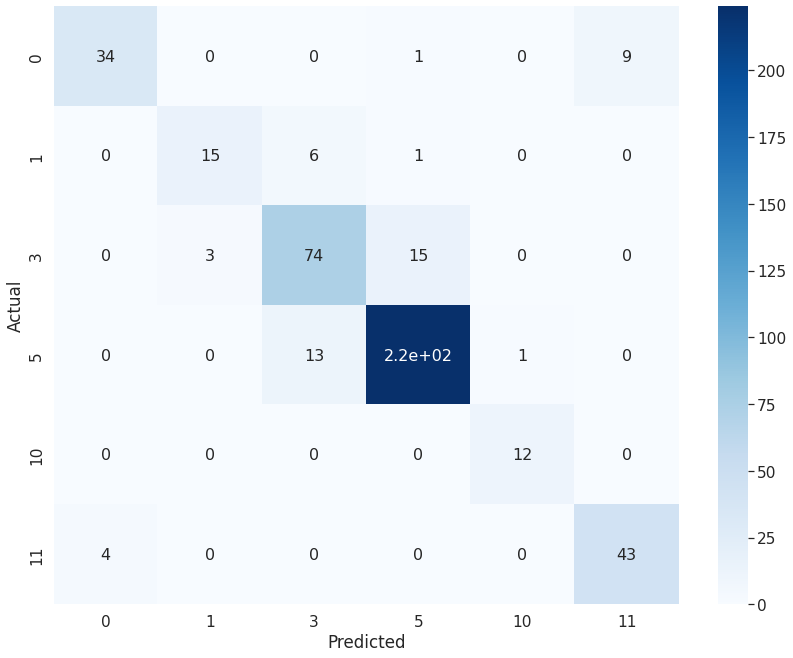

In [ ]:
def draw_confusion_matrix():
  target_names = ['0', '1', '3', '5', '10', '11']

  preds, confusion_matrix_data =  predict_test_dataset()
  print(dl.test_dataset.data.label.values[dl.test_dataset.data.label.values == preds])
  # preds, confusion_matrix_data =  predict_validate_dataset()
  df_cm = pd.DataFrame(confusion_matrix_data, columns=target_names, index = target_names)
  df_cm.index.name = 'Actual'
  df_cm.columns.name = 'Predicted'
  plt.figure(figsize = (14,11))
  sn.set(font_scale=1.4)#for label size
  sn.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 16})# font size
draw_confusion_matrix()

In [ ]:
state.best_acc

0.9069767441860465

# Close Log

In [ ]:
writer.close()
%load_ext tensorboard
%tensorboard --logdir=runs

Reusing TensorBoard on port 6006 (pid 1161), started 0:25:09 ago. (Use '!kill 1161' to kill it.)

<IPython.core.display.Javascript object>